In [1]:
# pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org install --upgrade pip setuptools

In [2]:
# pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org install --upgrade install scikit-learn

In [3]:
# pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org install Cython

In [4]:
# pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org install lightgbm

In [5]:
# pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org install dask sidetable matplotlib

In [6]:
# pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org install causalml

In [7]:
# pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org install duecredit ipywidgets

In [8]:
# pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org install pyarrow

In [9]:
import os
import sys
import pandas as pd
import dask.dataframe as dd
import sidetable
import numpy as np

import matplotlib.pyplot as plt
import importlib
from typing import List, Dict, Union
import lightgbm as lgb

import causalml
import causalml.metrics as cmetrics
import causalml.inference.tree as ctree
import causalml.inference.meta.rlearner as rlearner

In [10]:
import featurelib as fl

In [11]:
def dask_groupby(
    data: dd.DataFrame,
    by: List[str],
    config: Dict[str, Union[str, List[str]]]
) -> dd.DataFrame:
    data_ = data.copy()
    dask_agg_config = dict()

    for col, aggs in config.items():
        aggs = aggs if isinstance(aggs, list) else [aggs]
        for agg in aggs:
            fictious_col = f'{col}_{agg}'
            data_ = data_.assign(**{fictious_col: lambda d: d[col]})
            dask_agg_config[fictious_col] = agg

    result = data_.groupby(by=by).agg(dask_agg_config)
    return result

In [12]:
class ReceiptsBasicFeatureCalcer(fl.DateFeatureCalcer):
    name = 'receipts_basic'
    keys = ['customer_id']

    def __init__(self, delta: int, **kwargs):
        self.delta = delta
        super().__init__(**kwargs)

    def compute(self) -> dd.DataFrame:
        receipts = self.engine.get_table('receipts')
        
        date_from = self.date_to - self.delta
        date_mask = (receipts['date'] >= date_from) & (receipts['date'] < self.date_to)

        features = receipts.loc[date_mask]
        features = dask_groupby(
            features,
            by=['customer_id'],
            config={
                "purchase_sum": ["sum", "max", "min", "mean"],
                "discount": ["sum"],
                "date": ["min", "max", "count"],
            }
        )
        features = (
            features
            .assign(
                mean_time_interval=lambda d: (
                    (d['date_max'] - d['date_min']) / (d['date_count'] - 1)
                )
            )
            .assign(time_since_last=lambda d: self.date_to - d['date_max'])
        )

        features = features.reset_index()
        features = features.rename(columns={
            col: col + f'__{self.delta}d' for col in features.columns if col not in self.keys
        })

        return features

In [13]:
class AgeGeoCalcer(fl.FeatureCalcer):
    name = 'age_geo'
    keys = ['customer_id']

    def compute(self) -> dd.DataFrame:
        customers_info = self.engine.get_table('customers')
        return customers_info[self.keys + ['age', 'location']]

In [14]:
class CampaignInfoCalcer(fl.DateFeatureCalcer):
    name = 'campaigns_info'
    keys = ['customer_id']
    
    def compute(self) -> dd.DataFrame:
        campaigns = self.engine.get_table('campaigns')
        date_mask = campaigns['date'] == self.date_to

        result = (
            self.engine.get_table('campaigns')
            .loc[date_mask]
            [[
                'customer_id',
                'n_offer_days', 'target_group_flag', 'date'
            ]]
            .rename(columns={'date': 'campaign_date'})
        )
        return result


In [15]:
fl.register_calcer(ReceiptsBasicFeatureCalcer)
fl.register_calcer(AgeGeoCalcer)
fl.register_calcer(CampaignInfoCalcer)

In [16]:
engine = fl.Engine(tables={
    'receipts': dd.read_parquet('receipts.parquet'),
    'customers': dd.read_csv('customers.csv'),
    'campaigns': dd.read_csv('campaigns.csv'),
})

In [17]:
calcers_config = [
    {
        'name': 'receipts_basic',
        'args': {
            'date_to': 102, 'delta': 5
        }
    },
    {
        'name': 'receipts_basic',
        'args': {
            'date_to': 102, 'delta': 15
        }
    },
    {
        'name': 'receipts_basic',
        'args': {
            'date_to': 102, 'delta': 50
        }
    },
    {
        'name': 'receipts_basic',
        'args': {
            'date_to': 102, 'delta': 100
        }
    },
    { # target period
        'name': 'receipts_basic',
        'args': {
            'date_to': 132, 'delta': 30
        }
    },
    { # offer period
        'name': 'receipts_basic',
        'args': {
            'date_to': 109, 'delta': 7
        }
    },
    {
        'name': 'age_geo',
        'args': {}
    },
    {
        'name': 'campaigns_info',
        'args': {'date_to': 102}
    }
]

In [18]:
raw_data_train = fl.compute_features(engine, features_config=calcers_config)

In [19]:
raw_data_train = raw_data_train.compute()

In [20]:
raw_data_train.shape

(2000000, 66)

In [21]:
def fix_column_names(data: pd.DataFrame) -> pd.DataFrame:
    for _days in [30, 7]:
        for col_name in [
            f'purchase_sum_sum__{_days}d',
            f'purchase_sum_max__{_days}d',
            f'purchase_sum_min__{_days}d',
            f'purchase_sum_mean__{_days}d',
            f'discount_sum__{_days}d',
            f'date_min__{_days}d',
            f'date_max__{_days}d',
            f'date_count__{_days}d',
            f'mean_time_interval__{_days}d',
            f'time_since_last__{_days}d'
        ]:
            data = data.rename(columns={col_name: 'target__' + col_name})
    return data

In [22]:
MARGIN_RATE = 0.35
MESSAGE_COST = 1.0


def _transform(data: pd.DataFrame) -> pd.DataFrame:
    data.fillna({'target_group_flag': 0}, inplace=True)
    data['target_profit'] = (
        MARGIN_RATE * data['target__purchase_sum_sum__30d'].fillna(0.0)
        - MESSAGE_COST * data['target_group_flag'].fillna(0)
        - data['target__discount_sum__30d'].fillna(0)
    )
    return data

In [23]:
data_train = fix_column_names(raw_data_train)
data_train = _transform(data_train)

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
fit_index, val_index = train_test_split(data_train.index, test_size=0.5, random_state=165)

In [26]:
calcers_config = [
    {
        'name': 'receipts_basic',
        'args': {
            'date_to': 250, 'delta': 5
        }
    },
    {
        'name': 'receipts_basic',
        'args': {
            'date_to': 250, 'delta': 15
        }
    },
    {
        'name': 'receipts_basic',
        'args': {
            'date_to': 250, 'delta': 50
        }
    },
    {
        'name': 'receipts_basic',
        'args': {
            'date_to': 250, 'delta': 100
        }
    },
#     { # target period
#         'name': 'receipts_basic',
#         'args': {
#             'date_to': 132, 'delta': 30
#         }
#     },
#     { # offer period
#         'name': 'receipts_basic',
#         'args': {
#             'date_to': 109, 'delta': 7
#         }
#     },
    {
        'name': 'age_geo',
        'args': {}
    },
#     {
#         'name': 'campaigns_info',
#         'args': {'date_to': 102}
#     }
]

In [27]:
raw_data_serve = fl.compute_features(engine, features_config=calcers_config)

In [28]:
raw_data_serve = raw_data_serve.compute()

In [29]:
data_serve = fix_column_names(raw_data_serve)

In [30]:
cols_features_n1 = [
    'date_count__100d',
    'purchase_sum_sum__100d',
    'purchase_sum_max__100d',
    'purchase_sum_min__100d',
    'purchase_sum_mean__100d',
    'mean_time_interval__100d',
    'time_since_last__100d',
    'date_count__5d',
    'purchase_sum_sum__5d',
    'purchase_sum_max__5d',
    'purchase_sum_min__5d',
    'purchase_sum_mean__5d',
    'mean_time_interval__5d',
    'age'
]

In [31]:
data_train.loc[fit_index].groupby(by=['target_group_flag']).agg({
    'target_profit': 'mean',
    'target__purchase_sum_sum__30d': 'mean',
    'target__discount_sum__30d': 'mean',
    'customer_id': 'count',
})

,target_profit,target__purchase_sum_sum__30d,target__discount_sum__30d,customer_id
target_group_flag,,,,
0.0,877.42898,3085.956567,0.000000,750708
1.0,874.89113,3084.030186,21.925679,249292


In [32]:
col_target = 'target_profit'
col_treatment = 'target_group_flag'

In [33]:
cols_features = cols_features_n1

In [34]:
model_n1 = rlearner.BaseRRegressor(
    learner=lgb.LGBMRegressor(),
    control_name=0,
    n_fold=4,
    random_state=165
)

In [35]:
_p_score_const = data_train.loc[fit_index, col_treatment].value_counts(normalize=True).loc[1]
_p_scores = pd.Series(data=_p_score_const, index=fit_index)
model_n1.fit(
    X=data_train.loc[fit_index, cols_features].fillna(0).values,
    treatment=data_train.loc[fit_index, col_treatment].values,
    y=data_train.loc[fit_index, col_target].values,
    p=_p_scores
)

In [36]:
_eval_data = data_train.loc[val_index, cols_features + [col_treatment, col_target]]
_eval_data['score'] = model_n1.predict(_eval_data[cols_features])
_eval_data = _eval_data[['score', col_treatment, col_target]]

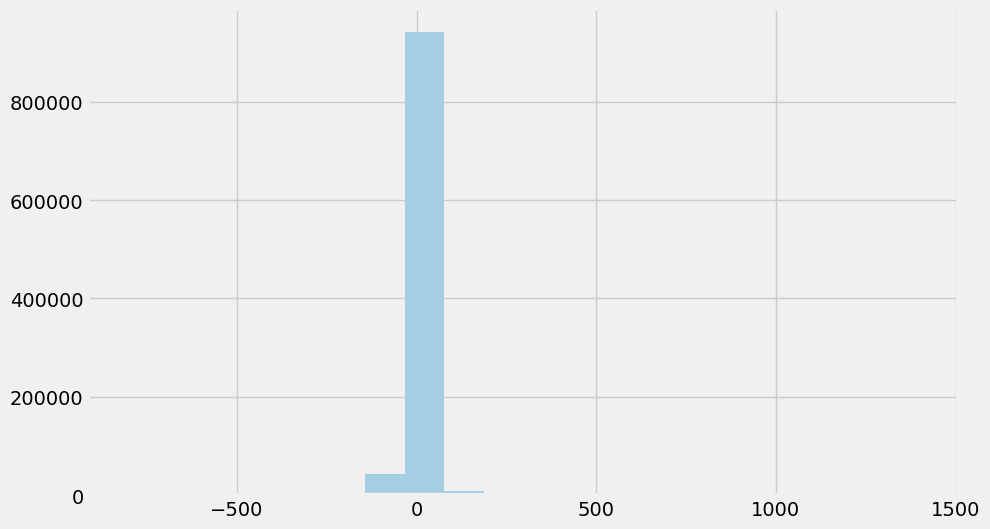

In [37]:
plt.figure(figsize=(10, 6))
plt.hist(_eval_data['score'], bins=20)
plt.show()

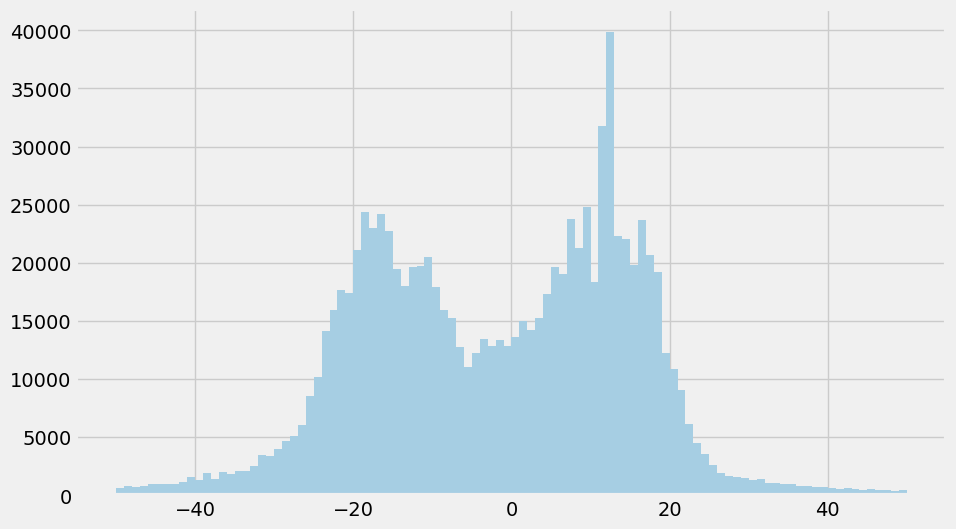

In [38]:
plt.figure(figsize=(10, 6))
plt.hist(_eval_data['score'], bins=100, range=(-50, 50))
plt.show()

In [39]:
np.percentile(_eval_data['score'], 5)

-31.719384391051946

In [40]:
np.percentile(_eval_data['score'], 95)

23.170024412933266

In [41]:
_eval_data['score'].describe()

count    1000000.000000
mean          -1.981109
std           31.332788
min         -802.790302
25%          -16.126859
50%           -0.692813
75%           12.265208
max         1398.041739
Name: score, dtype: float64

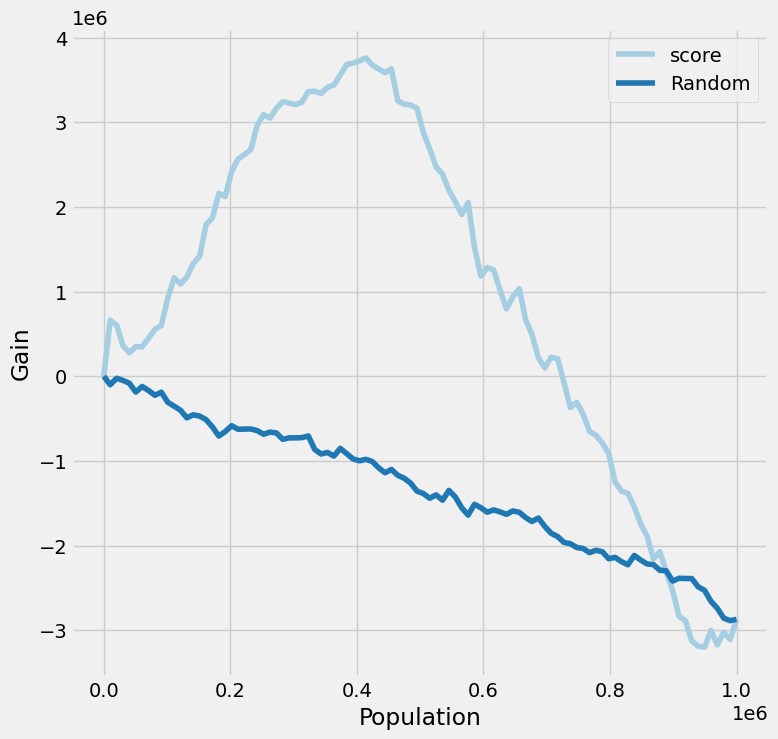

In [42]:
cmetrics.plot_gain(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col=col_target,
)

In [43]:
data_serve['model_n1_pred'] = model_n1.predict(data_serve[cols_features_n1])

In [44]:
data_serve['model_n1_pred'].describe()

count    2.000000e+06
mean    -1.997854e+00
std      3.133558e+01
min     -9.362994e+02
25%     -1.612686e+01
50%     -7.660856e-01
75%      1.226521e+01
max      1.423888e+03
Name: model_n1_pred, dtype: float64

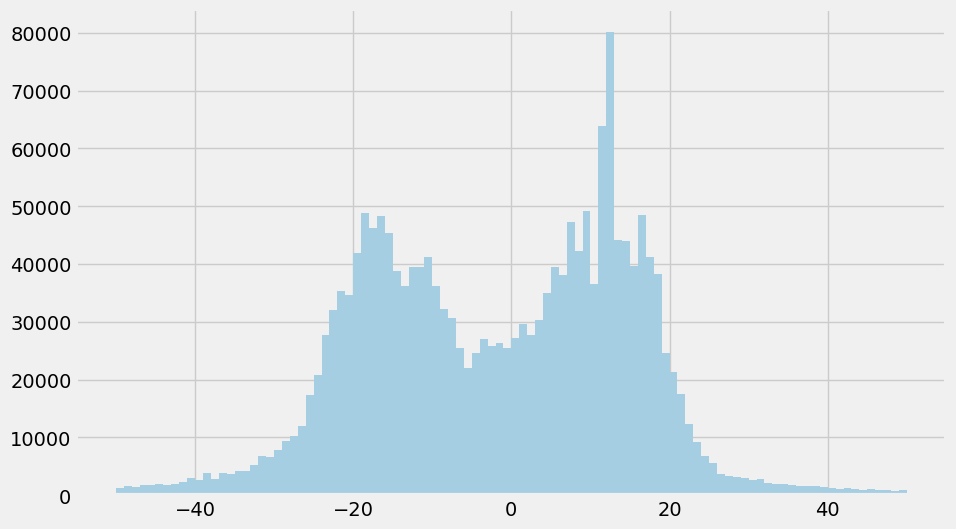

In [45]:
plt.figure(figsize=(10, 6))
plt.hist(data_serve['model_n1_pred'], bins=100, range=(-50, 50))
plt.show()

In [46]:
(data_serve['model_n1_pred'] > 5.0).mean()

0.4151065

In [47]:
data_serve[data_serve['model_n1_pred'] > 5.0]['customer_id'].to_csv('submission_n1.csv', index=None)